In [2]:
import numpy as np
from qiskit import QuantumCircuit
import qiskit
from qiskit import quantum_info
from qiskit.execute_function import execute
from qiskit import BasicAer
from qiskit.circuit import ParameterVector
from scipy.optimize import minimize

from numpy import random
%load_ext autoreload
%autoreload 2

from Part1 import encode
# Load MNIST dataset
DATA_PATH = '../data'
images = np.load(DATA_PATH+'/images.npy')
labels = np.load(DATA_PATH+'/labels.npy')

In [3]:
# first we need to encode it, lets assume this is done
ansatz = QuantumCircuit(8, name="Ansatz")

In [4]:
# We now define a two qubit unitary as defined in [3]
def conv_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    target.cx(1, 0)
    target.rz(np.pi / 2, 0)
    return target

def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits * 3)
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3
    for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc

def pool_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)

    return target

def pool_layer(sources, sinks, param_prefix):
    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits // 2 * 3)
    for source, sink in zip(sources, sinks):
        qc = qc.compose(pool_circuit(params[param_index : (param_index + 3)]), [source, sink])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc

In [5]:
# First Convolutional Layer
ansatz.compose(conv_layer(8, "с1"), list(range(8)), inplace=True)

# First Pooling Layer
ansatz.compose(pool_layer([0, 1, 2, 3], [4, 5, 6, 7], "p1"), list(range(8)), inplace=True)

# Second Convolutional Layer
ansatz.compose(conv_layer(4, "c2"), list(range(4, 8)), inplace=True)

# Second Pooling Layer
ansatz.compose(pool_layer([0, 1], [2, 3], "p2"), list(range(4, 8)), inplace=True)

# Third Convolutional Layer
ansatz.compose(conv_layer(2, "c3"), list(range(6, 8)), inplace=True)

# Third Pooling Layer
ansatz.compose(pool_layer([0], [1], "p3"), list(range(6, 8)), inplace=True)

In [6]:
# Combining the feature map and ansatz
def build_variational_circuit(image):
    circuit = QuantumCircuit(8)
    encoded_circuit = encode(image)
    circuit.compose(encoded_circuit,range(8), inplace=True)
    circuit.compose(ansatz, range(8), inplace=True)
    return circuit


(16, 16)


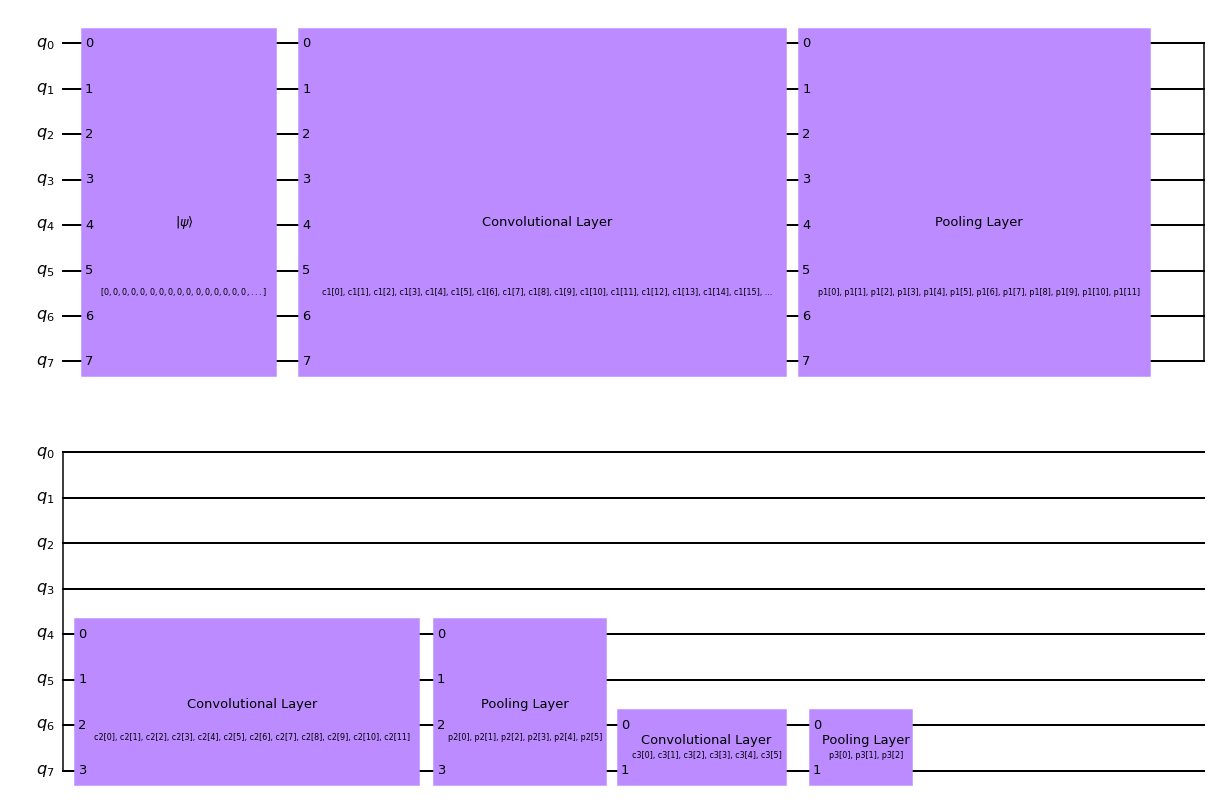

In [7]:
build_variational_circuit(images[0]).draw("mpl")

In [8]:
# each convolutional layer: num_qubits * 3 parameters = 24 parameters
# each pooling layer has: num_qubits // 2 * 3 = 12 parameters

"""
24 + 12
12 + 6
6 + 3
"""

'\n24 + 12\n12 + 6\n6 + 3\n'

In [9]:
24 + 12 + 12 + 6 + 6 +3 

63

In [10]:
def simulate(circuit: qiskit.QuantumCircuit) -> dict:
    """Simulate the circuit, give the state vector as the result."""
    backend = BasicAer.get_backend('statevector_simulator')
    job = execute(circuit, backend)
    result = job.result()
    state_vector = result.get_statevector()
    
    histogram = dict()
    for i in range(len(state_vector)):
        population = abs(state_vector[i]) ** 2
        if population > 1e-9:
            histogram[i] = population
    return histogram
    

def histogram_to_category(histogram):
    """This function take a histogram representations of circuit execution results, and process into labels as described in 
    the problem description."""
    assert abs(sum(histogram.values())-1)<1e-8
    positive=0
    for key in histogram.keys():
        digits = bin(int(key))[2:].zfill(20)
        if digits[-1]=='0':
            positive+=histogram[key]
        
    return positive

In [11]:
# TODO:
# create proper loss function: using the labels
# create optimization loop: start with a random guess
# COBYLA
# https://quantumcomputing.stackexchange.com/questions/20718/software-tools-to-train-quantum-circuits-with-parameters

In [12]:
images.shape

(2000, 28, 28)

In [13]:
def loss(x, samples, labels):
    # x must be of length: 63
    # y: actual label
    L = 0
    m = len(samples)
    for s,y in zip(samples, labels):
        circ = build_variational_circuit(s)
        histogram = simulate(circ.bind_parameters(x))
        y_hat = histogram_to_category(histogram=histogram)
        L += y*np.log(y_hat) + (1-y)*np.log(1-y_hat)

    return -L/m

def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

initial_guess = random.rand(63)*np.pi
result = minimize(loss, initial_guess, method='cobyla', args=(images[:20], labels[:20]), options={'maxiter':20})

(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(

In [18]:
initial_guess

array([0.17753901, 1.16825432, 2.25065587, 2.05983444, 2.37335565,
       2.96867951, 2.66620946, 0.93473782, 0.46904491, 1.93696274,
       2.25729178, 2.90580596, 2.38242857, 0.38478628, 1.35426748,
       2.62008203, 1.4251261 , 1.55260376, 2.17833918, 1.64809   ,
       2.22075572, 1.46648752, 3.07253832, 1.90318909, 1.549929  ,
       2.16397369, 2.21295044, 3.06595192, 0.84800932, 1.24629909,
       1.16466671, 2.91584388, 0.86924855, 2.5832011 , 1.14334995,
       1.75432907, 1.23390848, 1.55053025, 0.80053314, 1.68374233,
       0.63686003, 0.74319539, 0.63390021, 0.12646025, 2.26955989,
       2.7396861 , 2.04177491, 0.07993979, 2.46324832, 2.07726107,
       0.01731252, 0.99587202, 1.91310308, 1.44644664, 3.12143253,
       1.65319731, 2.04663827, 0.01165186, 1.39416411, 1.62874707,
       1.70534828, 0.9835689 , 1.7746556 ])

     fun: 0.6958477546595325
   maxcv: 0.0
 message: 'Maximum number of function evaluations has been exceeded.'
    nfev: 20
  status: 2
 success: False
       x: array([0.17753901, 2.16825432, 2.25065587, 2.05983444, 2.37335565,
       2.96867951, 3.66620946, 0.93473782, 0.46904491, 1.93696274,
       2.25729178, 2.90580596, 3.38242857, 0.38478628, 1.35426748,
       2.62008203, 1.4251261 , 1.55260376, 2.17833918, 1.64809   ,
       2.22075572, 1.46648752, 3.07253832, 1.90318909, 1.549929  ,
       2.16397369, 2.21295044, 3.06595192, 0.84800932, 1.24629909,
       1.16466671, 2.91584388, 0.86924855, 2.5832011 , 1.14334995,
       1.75432907, 1.23390848, 1.55053025, 0.80053314, 1.68374233,
       0.63686003, 0.74319539, 0.63390021, 0.12646025, 2.26955989,
       2.7396861 , 2.04177491, 0.07993979, 2.46324832, 2.07726107,
       0.01731252, 0.99587202, 1.91310308, 1.44644664, 3.12143253,
       1.65319731, 2.04663827, 0.01165186, 1.39416411, 1.62874707,
       1.70534828, 0.9835689 , 1

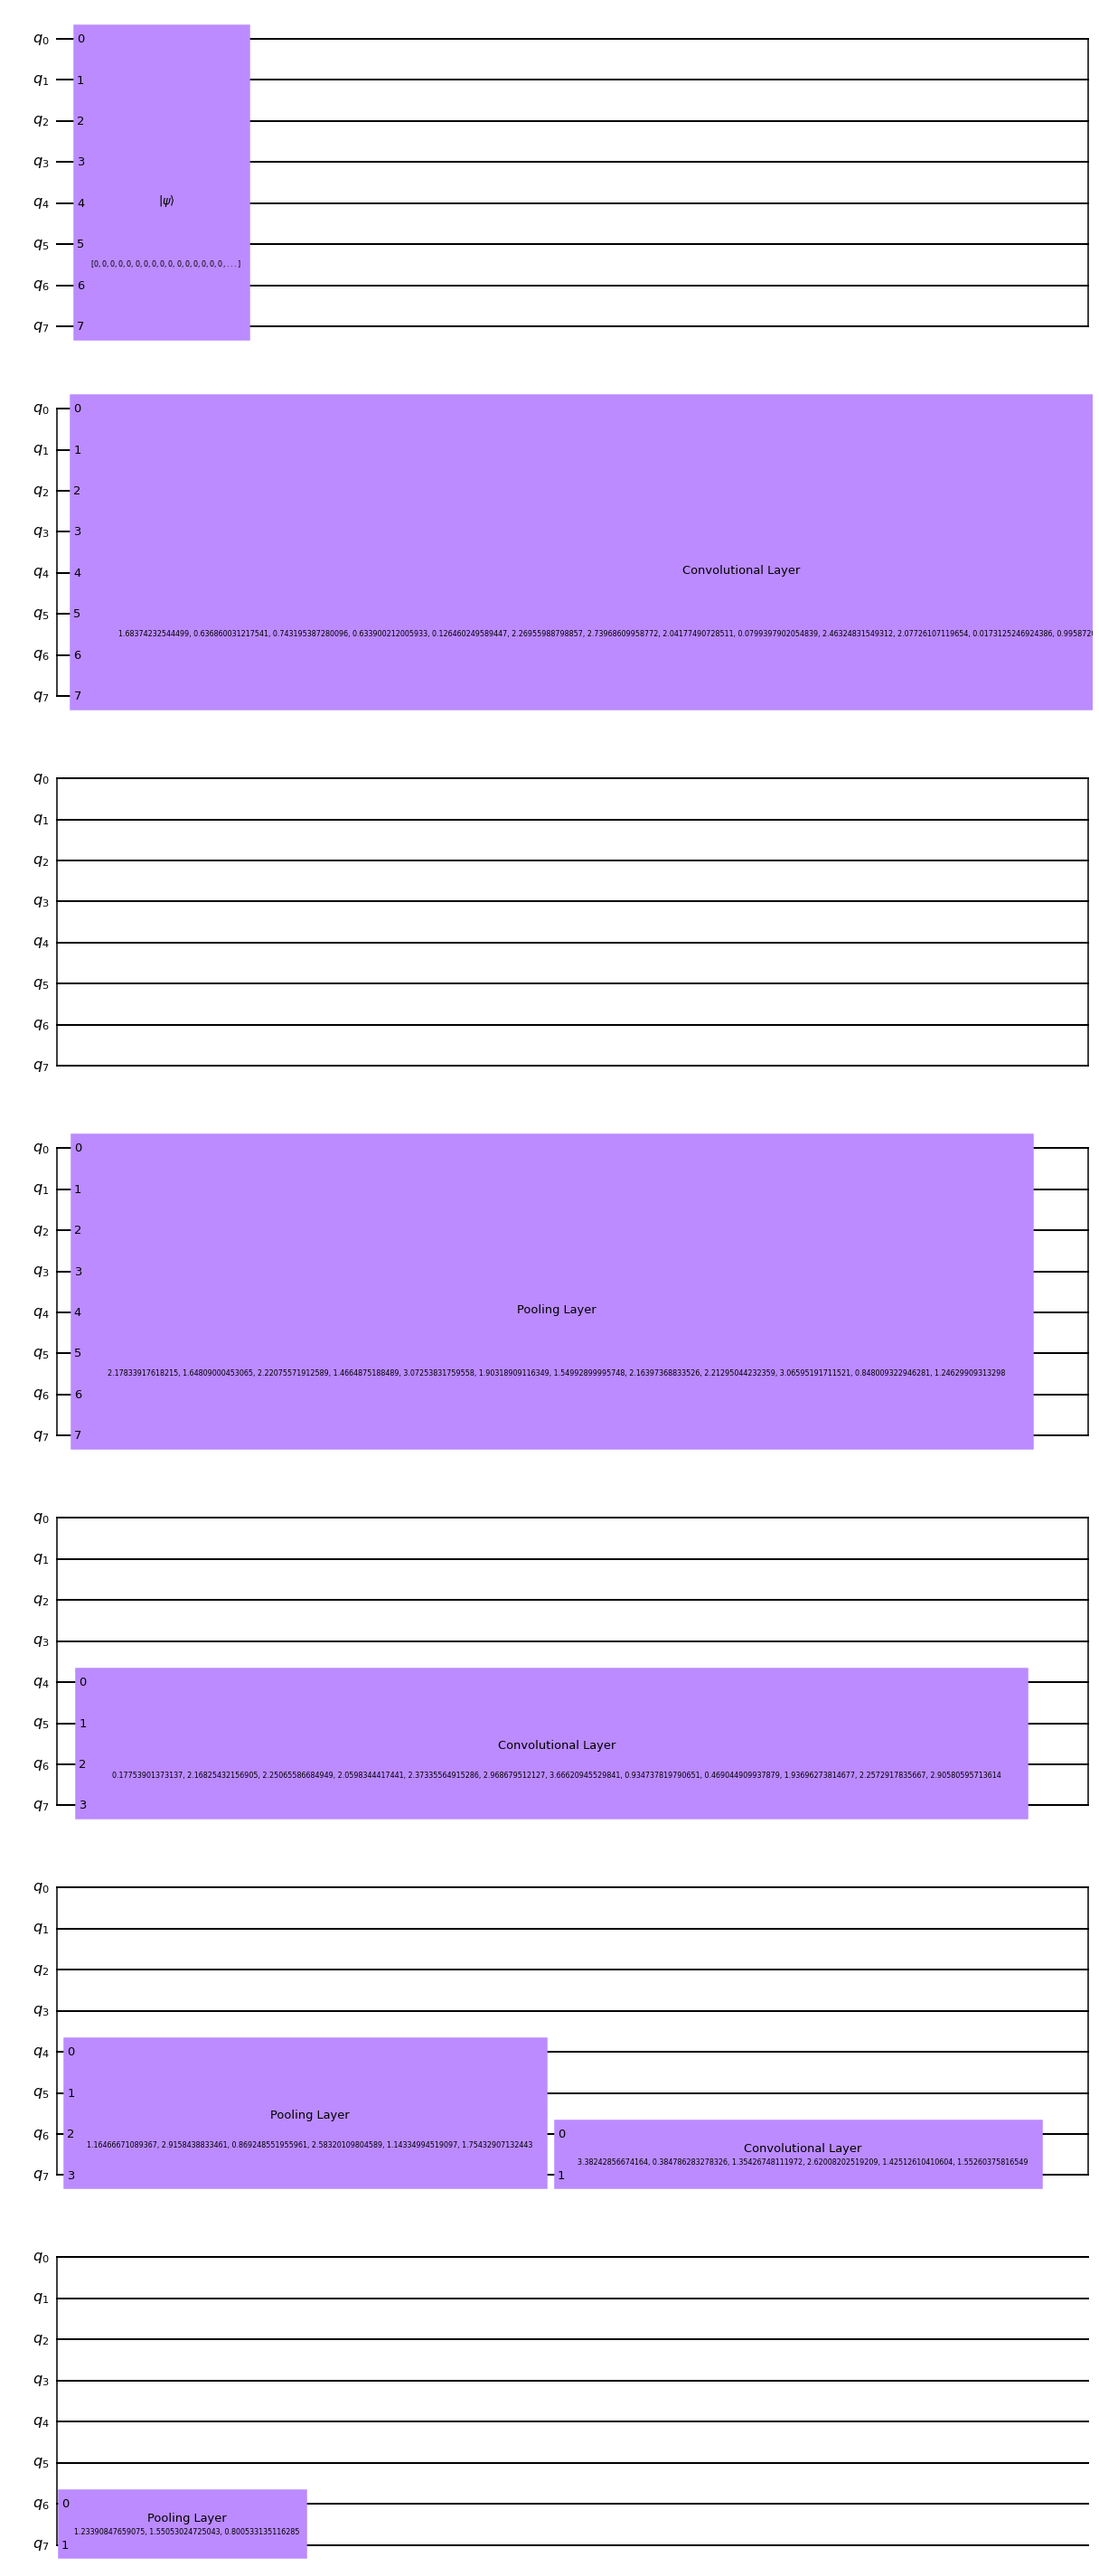

In [17]:
print(result)
print('Final circuit')
circ = build_variational_circuit(images[0])
circ.bind_parameters(result.x).draw('mpl')



In [ ]:
# it takes already quite a lot. I think it would be better if i decrease the number of parameters